# Случайные процессы. Прикладной поток.
## Практическое задание 8

**Правила:**

* Выполненную работу нужно отправить на почту `probability.diht@yandex.ru`, указав тему письма `"[СП17] Фамилия Имя - Задание 8"`. Квадратные скобки обязательны, внутри них пробела быть не должно. Вместо `Фамилия Имя` нужно подставить свои фамилию и имя.
* Прислать нужно ноутбук и его pdf-версию. Названия файлов должны быть такими: `7.N.ipynb` и `7.N.pdf`, где `N` - ваш номер из таблицы с оценками.
* Никакой код из данного задания при проверке запускаться не будет.
* При выполнении задания можно использовать код с семинара. Во всяком случае ноутбук точно стоит посмотреть.
------------------

В файле electricity.csv (<a href="https://rdrr.io/cran/stR/man/electricity.html">отсюда</a>) cодержится информация о максимальном спросе на электричество (Consumption) в штате Виктория (Австралия) за 30-минутные интервалы с 10 января 2000 в течении 115 дней, а так же информация о температуре воздуха (Temperature) за эти же промежутки времени.

In [1]:
import warnings
from tqdm import tqdm_notebook
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sps

from statsmodels.sandbox.stats.multicomp import multipletests
from statsmodels.tsa.seasonal import seasonal_decompose

import statsmodels.api as sm

/usr/local/lib/python3.5/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def plotlabels(xlabel, ylabel, title="", fontsize=15):
    plt.xlabel(xlabel, fontsize=fontsize)
    plt.ylabel(ylabel, fontsize=fontsize)
    plt.title(title, fontsize=fontsize)
    plt.grid()
    
def subsample(x, size):
    return x[sps.randint.rvs(0, len(x), size=size)]

**Задание:**
__________________
1.Нарисуйте графики временных рядов температуры и потребления электричества.
Верно ли, что спрос на электричество зависит от температуры воздуха? Для ответа на
вопрос используйте коэффициенты корреляции, учитывая условия их применимости.

In [3]:
!cat electricity.csv | head -n 2

Id,Consumption,Temperature,Time,DailySeasonality,WeeklySeasonality
0,3853.4753920000003,20.9,0,0,48
cat: ошибка записи: Обрыв канала


In [4]:
df = pd.read_csv("electricity.csv")
print(df.values.shape)
df.head(5)

(5520, 6)


,Id,Consumption,Temperature,Time,DailySeasonality,WeeklySeasonality
0,0,3853.475392,20.90,0,0,48
1,1,3683.014105,20.70,1,1,49
2,2,3912.324031,20.50,2,2,50
3,3,3783.881181,20.05,3,3,51
4,4,3554.257244,19.60,4,4,52


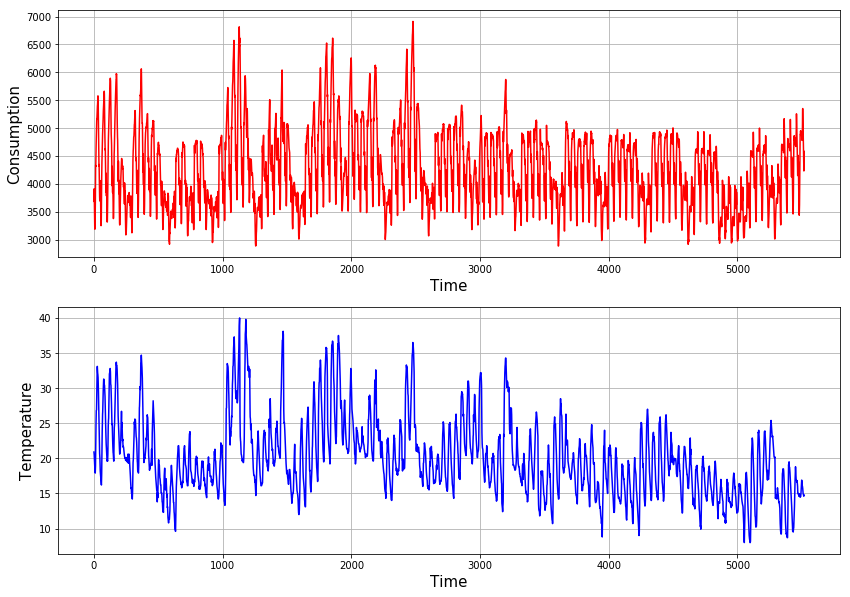

In [5]:
plt.figure(figsize=(14,10))
plt.subplot(211)
plotlabels("Time", "Consumption")
plt.plot(df.Time, df.Consumption, color="red")
plt.subplot(212)
plotlabels("Time", "Temperature")
plt.plot(df.Time, df.Temperature, color="blue")
plt.show()

**Комментарий:** Субъективный визуальный анализ утверждает, что да, зависимость есть. Применим объективные методы.

На семинаре было сказано, что коэф. кор. Пирсона хорошо работает только для нормальных выборок и только для
линейных зависимостей. Визуально зависимость похожа на растяжение и перенос, т.е. на линейную. 
Нормальность выборок оценим визуально по гистограммам ниже. (Ясно, что статистические тесты покажут не нормальность выборки)

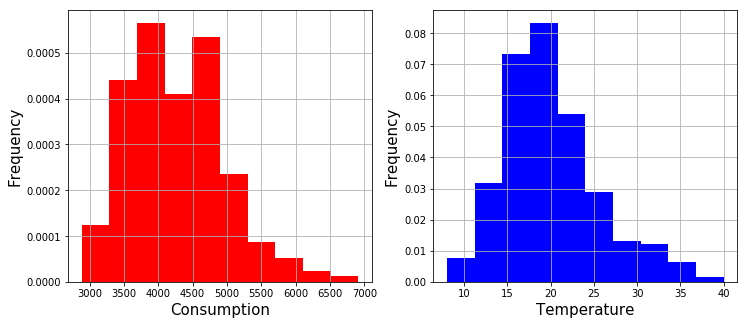

In [6]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plotlabels("Consumption", "Frequency")
plt.hist(df.Consumption, color="red", normed=True)
plt.subplot(122)
plotlabels("Temperature", "Frequency")
plt.hist(df.Temperature, color="blue", normed=True)
plt.show()

Визуально напоминуют нормальные распределения. Если произвести тест Шапиро-Уилка на нормальность выборок по подвыборке размера 100, то при малых pvalue можно считать выборки нормальными.

Тест Колмогорова-Смирнова на нормальность при тех же условиях считает выборки нормальными.

Далее будем считать, что применение  к.к. Пирсона осмыслено, с оговорками, конечно.

In [7]:
_, temp_pvalue_s = sps.shapiro(subsample(df.Temperature, 100))
_, cons_pvalue_s = sps.shapiro(subsample(df.Consumption, 100))

print("Тест Шапиро-Уилка")
print("pvalue (Температура) = %f.5\npvalue (Потребление) = %f.5"
      % (temp_pvalue_s, cons_pvalue_s))

def kstest_normal(x):
    params = sps.norm.fit(x)
    return sps.kstest(x, "norm", args=params)


print("Тест Колмогорова-Смирнова")
_, temp_pvalue_k = kstest_normal(subsample(df.Temperature, 100))
_, cons_pvalue_k = kstest_normal(subsample(df.Consumption, 100))

print("pvalue (Температура) = %f.5\npvalue (Потребление) = %f.5"
      % (temp_pvalue_k, cons_pvalue_k))

print("Результаты множественной проверки гипотез (отвергнуты ли):",
    multipletests([temp_pvalue_s, cons_pvalue_s,
                   cons_pvalue_k, cons_pvalue_k], method="bonferroni")[0])

Тест Шапиро-Уилка
pvalue (Температура) = 0.001266.5
pvalue (Потребление) = 0.000338.5
Тест Колмогорова-Смирнова
pvalue (Температура) = 0.017461.5
pvalue (Потребление) = 0.904069.5
Результаты множественной проверки гипотез (отвергнуты ли): [ True  True False False]


In [8]:
def r_describe(x, y, alpha=0.05, r = sps.pearsonr):
    r_value, pvalue = r(df.Consumption, df.Temperature)
    print("Метод : ", r.__name__)
    print("r = ", r_value)
    print("pvalue = ", pvalue)
    if pvalue < alpha:
        print ("Гипотеза о некоррелированости выборок отвергается.\n")
    else:
        print ("Гипотеза о некоррелированости выборок не отвергается.\n")
    return pvalue
        
r_pear = r_describe(df.Temperature, df.Consumption)

Метод :  pearsonr
r =  0.666558260161
pvalue =  0.0
Гипотеза о некоррелированости выборок отвергается.



Результат совпадает с визуальным анализом.

Проверим к.к. Спирмена и Кендалла, для них не было оговорено критериев применимости (например, на (http://www.machinelearning.ru) их не было найдено, хотя утверждалось (https://docs.scipy.org/), что коэффициент корреляции Спирмена не требует нормальности выборок)

In [9]:
r_spear = r_describe(df.Temperature, df.Consumption, r=sps.spearmanr)
r_kenda = r_describe(df.Temperature, df.Consumption, r=sps.kendalltau)

Метод :  spearmanr
r =  0.578054186069
pvalue =  0.0
Гипотеза о некоррелированости выборок отвергается.

Метод :  kendalltau
r =  0.413378142591
pvalue =  0.0
Гипотеза о некоррелированости выборок отвергается.



Добавим поправку на множественное тестирование гипотез.

In [10]:
multipletests([r_pear, r_spear, r_kenda])

(array([ True,  True,  True], dtype=bool),
 array([ 0.,  0.,  0.]),
 0.016952427508441503,
 0.016666666666666666)

**Комментарий:** Все применённые выше к.к. и визуальный анализ отвергают нулевую гипотезу о некоррелированости выборок. (Применимость критерия Пирсона принята с оговоркой о том, что наши приближённо нормальные выборки мы считаем нормальными)

_________________
2.Разделите временной ряд на две части: данные за последнюю неделю (последние 48*7
измерений) назовем тестовыми данными, а все остальное — обучающими данными.
Пункты задания 3-6 выполните для обучающих данных.

In [11]:
divisor = 7 * 24 * 2  # 30 минут / измерение

df_train, df_test = df[:-divisor], df[-divisor:]
print(df.shape, df_train.shape, df_test.shape) # не маловато ли для тестовой выборки?

(5520, 6) (5184, 6) (336, 6)


________________________
3.Сколько типов сезонностей можно выделить в каждом из двух рядов (спрос на электричество и температура)? С помощью STL-декомпозиции в каждом ряде выделите тренд, все типы сезонности, остатки.

**Комментарий:** Названия столбцов в исходной таблице, графики и логика намекают, что можно выделить дневную и недельную сезонность. Разумно добавить ещё и месячную сезонность. Выделить годичную сезонность, имея данные за 115 дней проблематично, даже если она есть.

In [12]:
class Folder:
    pass

def decompose(X):
    temp = Folder()
    temp.src = X
    temp.seasonal_1 = seasonal_decompose(X, model='additive',
                                    filt=None, freq=48, two_sided=True).seasonal
    temp.seasonal_2 = seasonal_decompose(X - temp.seasonal_1, model='additive',
                                     freq=7*48).seasonal
    res = seasonal_decompose(X - temp.seasonal_1 - temp.seasonal_2, model='additive',
                                     freq=4*2*7*24)
    temp.seasonal_3 = res.seasonal
    temp.trend = res.trend
    temp.ost = X - (temp.seasonal_1 + temp.seasonal_2 + temp.seasonal_3 + temp.trend)
    return temp

temp = decompose(df_train.Temperature.values)
cons = decompose(df_train.Consumption.values)

In [13]:
temp.seasonal_1[np.isnan(temp.seasonal_1) == False], \
cons.seasonal_1[np.isnan(cons.seasonal_1) == False]

(array([-2.34663517, -2.57091476, -2.7952333 , ..., -1.51874868,
        -1.81472318, -2.08073272]),
 array([-250.44339603, -411.560405  , -176.04770495, ..., -440.13969916,
         -59.58821092,  -86.3585459 ]))

Температура


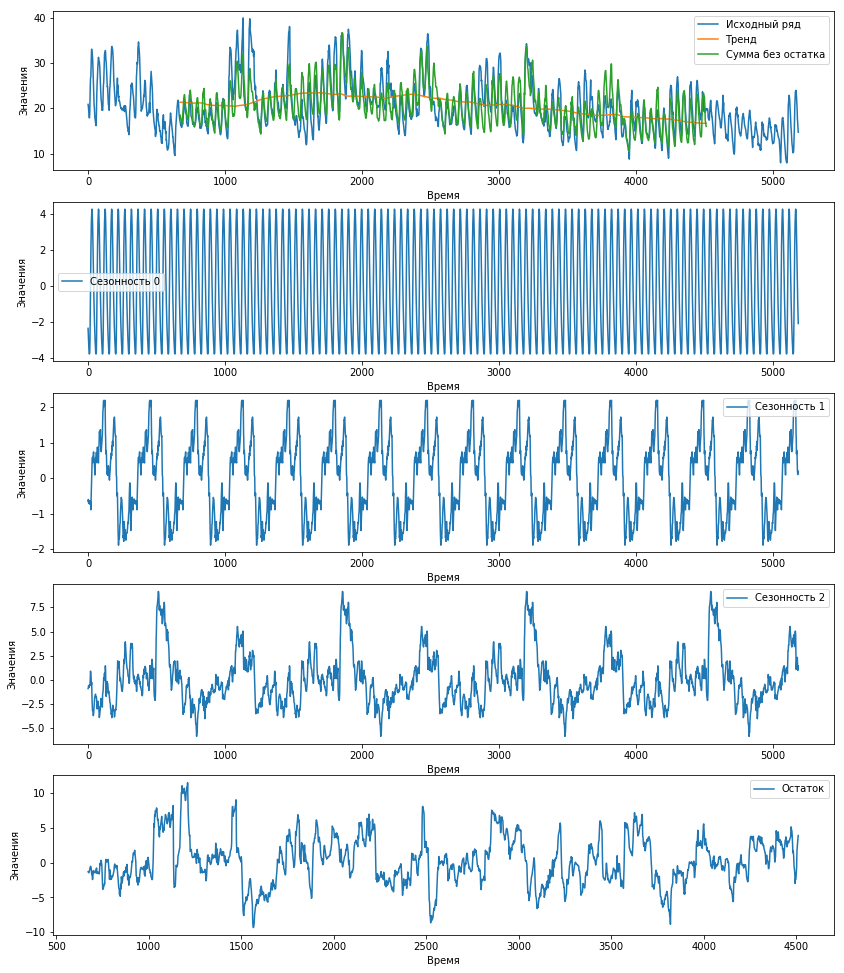

Потребление


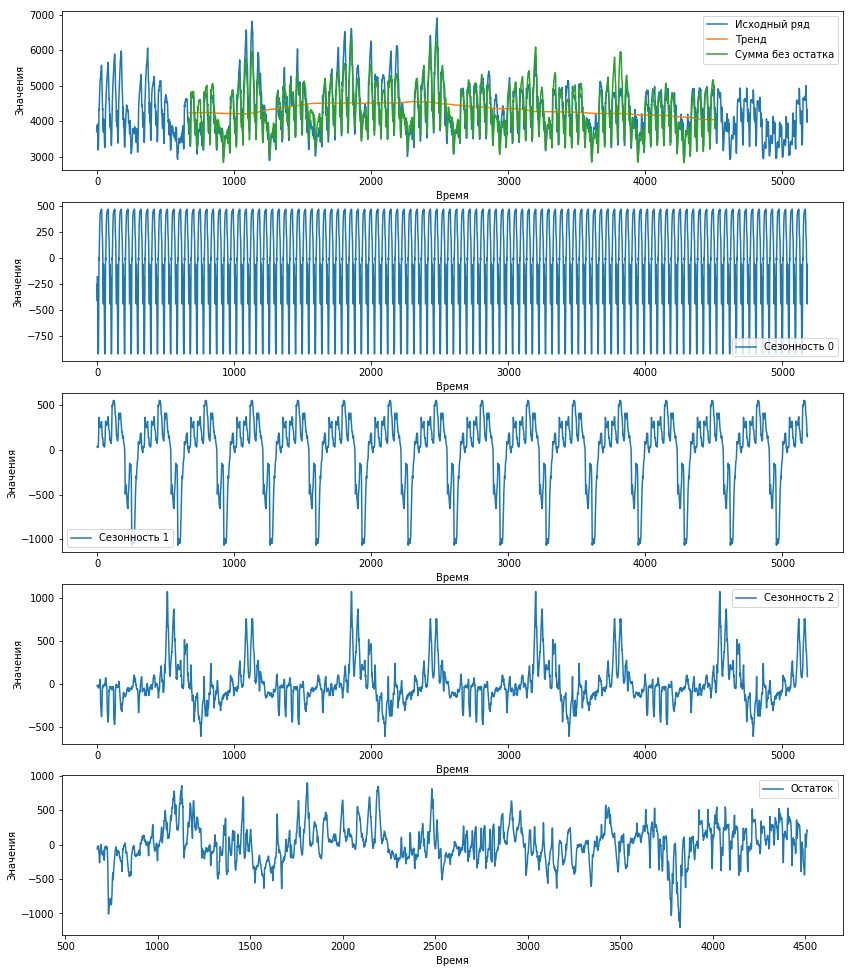

In [14]:
def plot_decomposition(time, source, trend, ost, seasonals):
    height = 2 + len(seasonals)
    plt.figure(figsize=(14,height * 3 + 2))
    
    plt.subplot(height, 1, 1)
    plt.xlabel("Время")
    plt.ylabel("Значения")
    plt.plot(time, source, label="Исходный ряд")
    
    ssum = np.copy(trend) 
    for s in seasonals:
        ssum += s
    plt.plot(time, trend, label="Тренд")
    plt.plot(time, ssum, label="Cумма без остатка")
    plt.legend()
    
    for i, s in enumerate(seasonals):
        plt.subplot(height, 1, 2 + i)
        plt.xlabel("Время")
        plt.ylabel("Значения")
        plt.plot(time, s, label="Сезонность %d" % i)
        plt.legend()
        ssum += s
        
    plt.subplot(height, 1, height)
    plt.xlabel("Время")
    plt.ylabel("Значения")
    plt.plot(time, ost, label="Остаток")


    plt.legend()
    plt.show()
    
print("Температура")
plot_decomposition(df_train.Time, df_train.Temperature, temp.trend, temp.ost,
                   [temp.seasonal_1, temp.seasonal_2, temp.seasonal_3])
print("Потребление")
plot_decomposition(df_train.Time, df_train.Consumption, cons.trend, cons.ost,
                   [cons.seasonal_1, cons.seasonal_2, cons.seasonal_3])

In [15]:
#plt.figure(figsize=(14,10))
#sm.tsa.seasonal_decompose(df_train.Temperature.values, freq=7*48).plot()

_________
4.С помощью критерия KPSS проверьте на стационарность исходные ряды и остатки,
полученные после применения STL-декомпозиции. Не забывайте про множественную
проверку гипотез.

In [16]:
from statsmodels.tsa.stattools import kpss
kpss_temp_pvalue = kpss(temp.src, regression='c', lags=None, store=False)[1]
kpss_cons_pvalue = kpss(cons.src, regression='c', lags=None, store=False)[1]

print("pvalue kpss для исходного ряда температуры = %.3f и потребления = %.3f"
      % (kpss_temp_pvalue, kpss_cons_pvalue))

pvalue kpss для исходного ряда температуры = 0.010 и потребления = 0.010


/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/stattools.py:1258: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


In [17]:
kpss_ost_temp_pvalue = kpss(temp.ost[np.isnan(temp.ost) == False],
                            regression='c', lags=None, store=False)[1]
kpss_ost_cons_pvalue = kpss(cons.ost[np.isnan(cons.ost) == False],
                            regression='c', lags=None, store=False)[1]


print(("pvalue kpss для остатков (после выделения сезонностей)"
    + " ряда температуры = %.3f и потребления = %.3f")
      % (kpss_ost_temp_pvalue, kpss_ost_cons_pvalue))

pvalue kpss для остатков (после выделения сезонностей) ряда температуры = 0.100 и потребления = 0.100


/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


**Комментарий:** Обратим внимание, что для исходного ряда pvalue меньше полученных, а для остатков - больше полученных (см Run-Time warning). Для множественного тестирования гипотез применим метод Бонферрони (другого же мы не знаем). Вспоминая, как он работает, а именно - умножает полученные pvalue на их число заметим, что при pvalue=0.05 нам не важно, что полученные в kpss значения не точные, а меньше или больше, т.к. $0.4 \geq 0.1 \geq 0.05 \geq 0.04 \geq 0.01$ и полученное значение получено верно. 

In [18]:
multipletests([kpss_temp_pvalue, kpss_cons_pvalue,
               kpss_ost_temp_pvalue, kpss_ost_cons_pvalue],
               method="bonferroni")

(array([ True,  True, False, False], dtype=bool),
 array([ 0.04,  0.04,  0.4 ,  0.4 ]),
 0.012741455098566168,
 0.0125)

Таким образом, исходные ряды НЕ являются стационарными (гипотеза о стационарности отвергнута), тогда как на остатки после разложения на тренд, три сезонности и собственно остаток, гипотеза о стационарности не отвергнута.

____________
5.С помощью преобразований **исходных** рядов приведите их к стационарным. По графикам ACF и PACF подберите параметры модели SARIMA(p, d, q) × (P, D, Q) s .

Посмотрим на графики исходных рядов.

Consumption


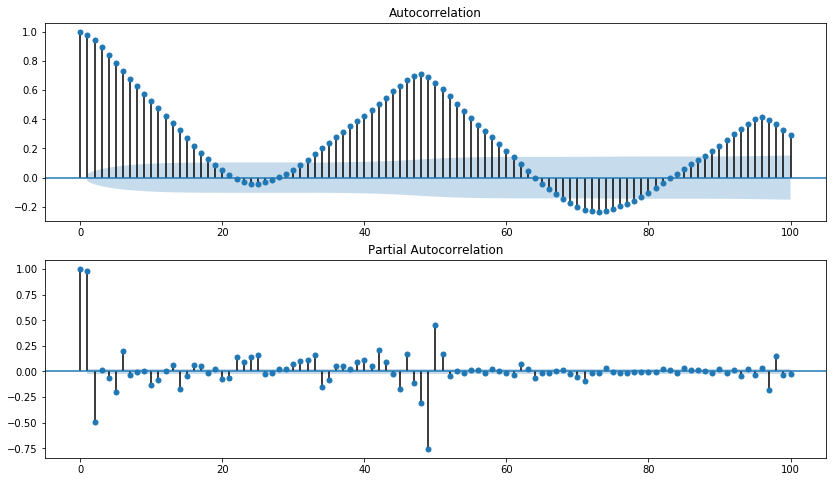

Temperature


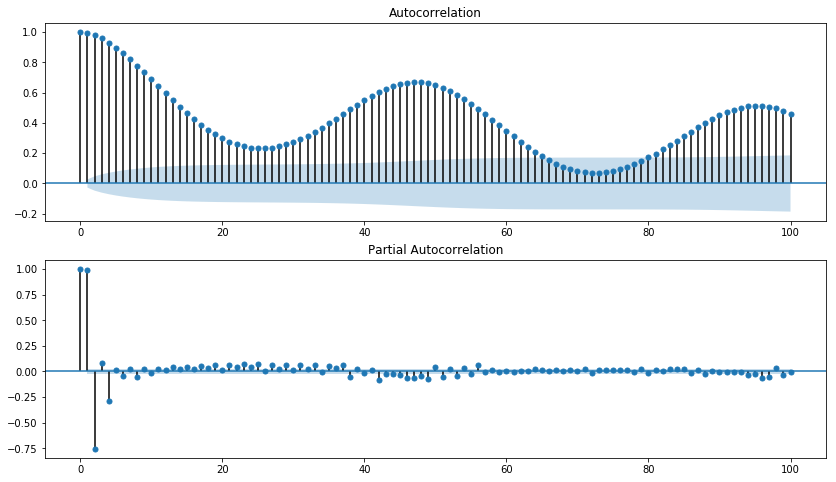

In [19]:
def acf_pacf_plot(X, name="", lags=100, ylim=None):
    print(name)
    fig = plt.figure(figsize=(14, 8))
    ax1 = fig.add_subplot(211)
    if not ylim is None:
        plt.ylim(ylim)
    fig = sm.graphics.tsa.plot_acf(X, lags=lags, ax=ax1)
    ax2 = fig.add_subplot(212)
    if not ylim is None:
        plt.ylim(ylim)
    fig = sm.graphics.tsa.plot_pacf(X, lags=lags, ax=ax2)
    plt.show()

acf_pacf_plot(df_train.Consumption, "Consumption")
acf_pacf_plot(df_train.Temperature, "Temperature")

Посмотрим на графики ACF, PACF для двух наборов преобразований:
1. Преобразование Бокса-Кокса с $\lambda=0$, недельное и дневное сезонные дифференцирования, обычное дифференцирование.
2. То же самое без преобразования Бокса-Кокса.

Предлагается применять дифференцирования от большего к меньшему (по периоду), так написано методичке небезызвестного курса на Coursera о машинном обучении. После преобразовании дополнительно проверим на стационарность ряды с помощью kpss

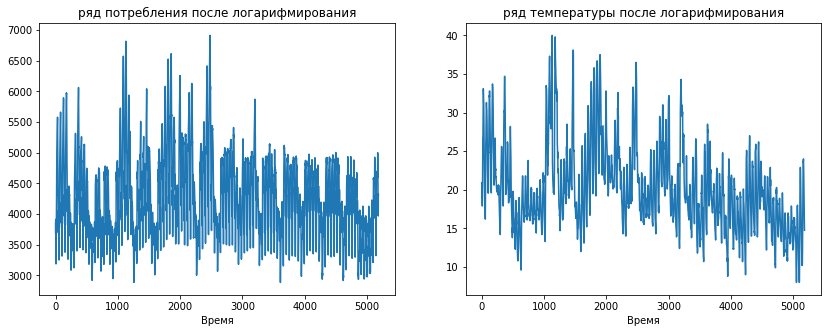

Consumption (c логарифмированием)


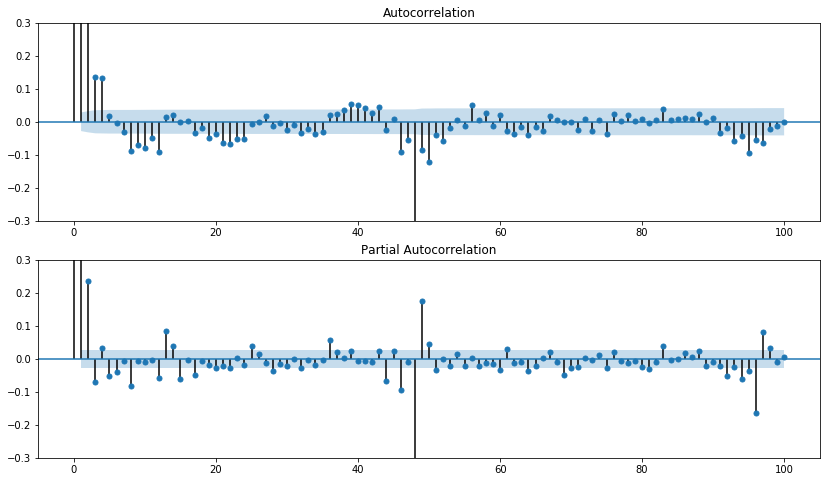

Temperature (c логарифмированием)


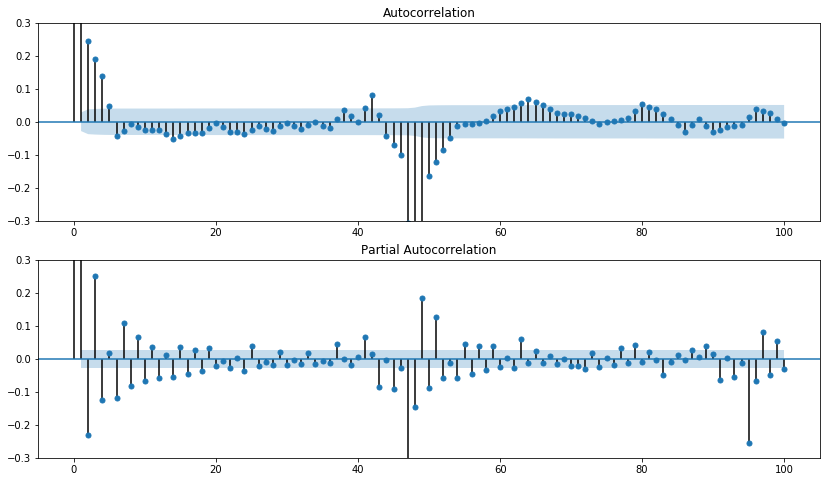

pvalue kpss для остатков (после выделения сезонностей) ряда температуры = 0.100 и потребления = 0.100


In [51]:
X_train_temp = df_train.Temperature.values
X_train_cons = df_train.Consumption.values

X_test_temp = df_test.Temperature.values
X_test_cons = df_test.Consumption.values

X_train_temp_ln = np.log(X_train_temp) # преобразование Бокса-Кокса
X_train_cons_ln = np.log(X_train_cons)

grid = np.arange(len(X_train_temp_ln))
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.plot(grid, X_train_cons)

plt.xlabel("логарифм потребления")
plt.xlabel("Время")
plt.title("ряд потребления после логарифмирования")
plt.subplot(122)
plt.plot(grid, X_train_temp)
plt.xlabel("логарифм температуры")
plt.xlabel("Время")
plt.title("ряд температуры после логарифмирования")
plt.show()


X_train_temp_s2 = X_train_temp_ln[7*48:] - X_train_temp_ln[:-7*48] 
X_train_cons_s2 = X_train_cons_ln[7*48:] - X_train_cons_ln[:-7*48]

X_train_temp_s12 = X_train_temp_s2[48:] - X_train_temp_s2[:-48]
X_train_cons_s12 = X_train_cons_s2[48:] - X_train_cons_s2[:-48]

X_train_temp_dt_s12 = X_train_temp_s12[1:] - X_train_temp_s12[:-1] 
X_train_cons_dt_s12 = X_train_cons_s12[1:] - X_train_cons_s12[:-1]

acf_pacf_plot(X_train_cons_dt_s12, "Consumption (c логарифмированием)", ylim=(-0.3, 0.3))
acf_pacf_plot(X_train_temp_dt_s12, "Temperature (c логарифмированием)", ylim=(-0.3, 0.3))

kpss_ost_temp_pvalue = kpss(X_train_temp_dt_s12,
                            regression='c', lags=None, store=False)[1]
kpss_ost_cons_pvalue = kpss(X_train_cons_dt_s12,
                            regression='c', lags=None, store=False)[1]


print(("pvalue kpss для остатков (после выделения сезонностей)"
    + " ряда температуры = %.3f и потребления = %.3f")
      % (kpss_ost_temp_pvalue, kpss_ost_cons_pvalue))

Заметим, что полученные ряды являются стационарными (гипотеза о стационарности не была отвергнута, значит и не будет отвергнута при множественном тестировании по методу Бонферрони)

По этому графику можно выбрать p = 5, q = 4 для Consumption и p = 4 (или ~18?, не очень понятно, как действовать в этом случае), q = 5 (выбор как с перезентации с семинара, по последним значимым пикам)

Числа P,Q предлагается выбирать как числа значимых пиков через сеозонности, для этого укрупним графики.

Consumption (c логарифмированием)


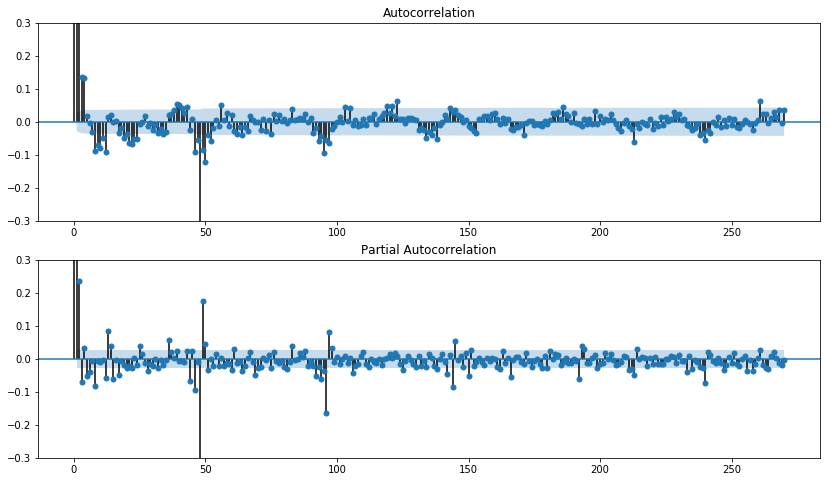

Temperature (c логарифмированием)


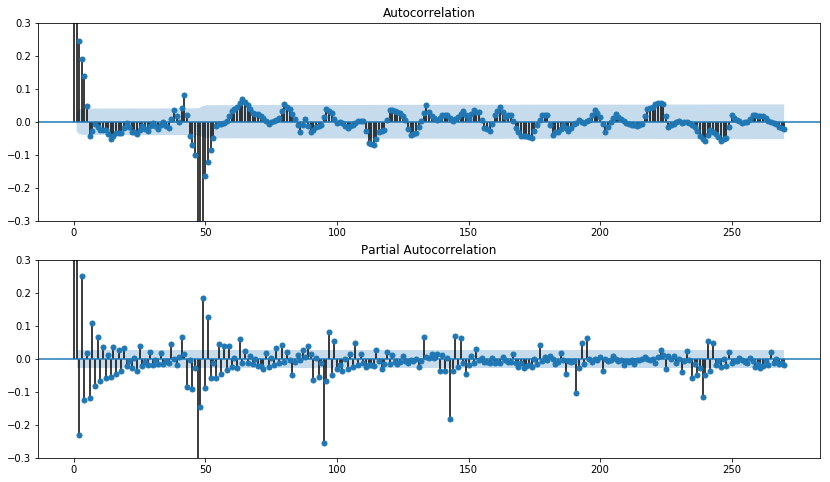

In [53]:
acf_pacf_plot(X_train_cons_dt_s12, "Consumption (c логарифмированием)", ylim=(-0.3, 0.3), lags=270)
acf_pacf_plot(X_train_temp_dt_s12, "Temperature (c логарифмированием)", ylim=(-0.3, 0.3), lags=270)


Для потребления Q = 2, P = 4 (или даже 5), для температуры Q = 2, P = 4 (5). Неудивительно, что для значимо коррелирующих рядов получаем одинаковые числа.
_____________
Посмотрим на ряды без преобразования Бокса-Кокса, логарифмирования (частный случай)

Consumption (БЕЗ логарифмирования)


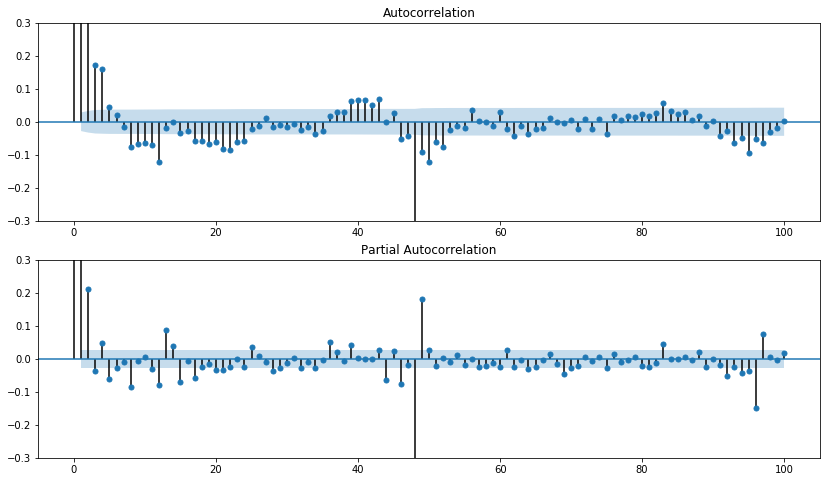

Temperature (БЕЗ логарифмирования)


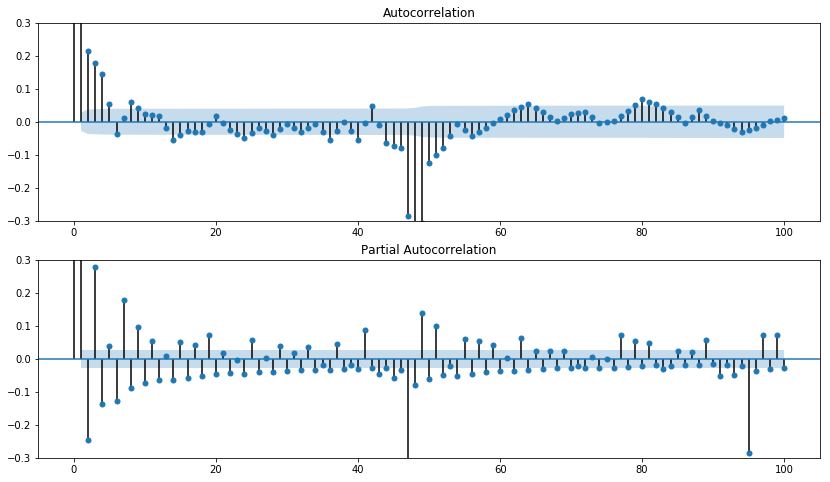

pvalue kpss для остатков (после выделения сезонностей) ряда температуры = 0.100 и потребления = 0.100


In [54]:
X_train_temp_s2 = X_train_temp[7*48:] - X_train_temp[:-7*48] 
X_train_cons_s2 = X_train_cons[7*48:] - X_train_cons[:-7*48]

X_train_temp_s12 = X_train_temp_s2[48:] - X_train_temp_s2[:-48]
X_train_cons_s12 = X_train_cons_s2[48:] - X_train_cons_s2[:-48]

X_train_temp_dt_s12 = X_train_temp_s12[1:] - X_train_temp_s12[:-1] 
X_train_cons_dt_s12 = X_train_cons_s12[1:] - X_train_cons_s12[:-1]

acf_pacf_plot(X_train_cons_dt_s12, "Consumption (БЕЗ логарифмирования)", ylim=(-0.3, 0.3))
acf_pacf_plot(X_train_temp_dt_s12, "Temperature (БЕЗ логарифмирования)", ylim=(-0.3, 0.3))

kpss_ost_temp_pvalue = kpss(X_train_temp_dt_s12,
                            regression='c', lags=None, store=False)[1]
kpss_ost_cons_pvalue = kpss(X_train_cons_dt_s12,
                            regression='c', lags=None, store=False)[1]


print(("pvalue kpss для остатков (после выделения сезонностей)"
    + " ряда температуры = %.3f и потребления = %.3f")
      % (kpss_ost_temp_pvalue, kpss_ost_cons_pvalue))

Заметим, что полученные ряды также являются стационарными (гипотеза о стационарности не была отвергнута, значит и не будет отвергнута при множественном тестировании по методу Бонферрони)

По этим графикам в целом опеределяются те же параметры p,q.

Посмотрим на укрупнённые графики для выбора P,Q.

Consumption (c логарифмированием)


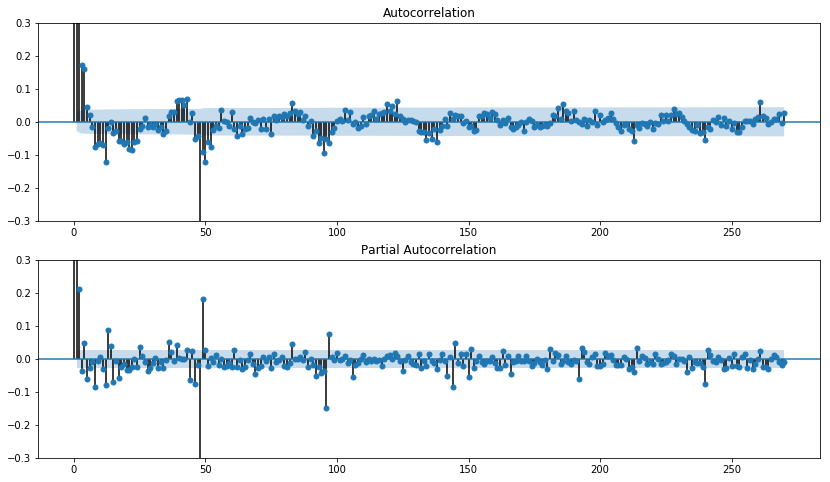

Temperature (c логарифмированием)


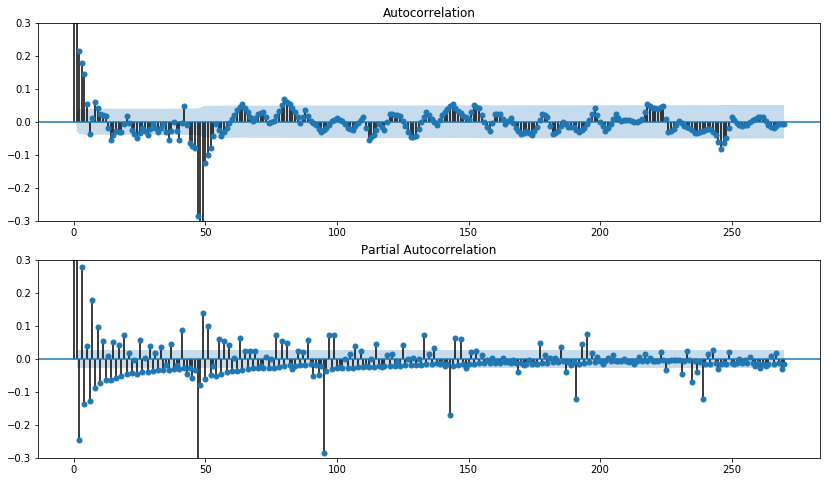

In [55]:
acf_pacf_plot(X_train_cons_dt_s12, "Consumption (c логарифмированием)", ylim=(-0.3, 0.3), lags=270)
acf_pacf_plot(X_train_temp_dt_s12, "Temperature (c логарифмированием)", ylim=(-0.3, 0.3), lags=270)


В целом мы получаем те же результаты. Везде несколько увеличилась по модулю корреляция, но не сильно значимо.
Преобразования Бокса-Кокса должны стабилизировать дисперсию, но в исходных рядах она визуально и субъективно более-менее стабильна, и в итоге мы получаем почти те же графики. Возможно, стоило выбирать параметр для преобразований Бокса-Кокса исходя из каких-то критериев, но выбор параметра для преобразования не обсуждался.

___________
6.С помощью поиска по сетке вокруг выбранных параметров подберите оптимальные параметры по значению AIC. Учтите, что из сделанных ранее преобразований ряда нужно оставить лишь некоторые. Другие, например, одна из сезонностей будут учтены параметрами модели.

**Внимание, далее идут костыли:** На полной обучающей выборке, ряде и на моём ноутбуке данная модель обучается очень долго, на фиксированных параметрах одна модель около часа. Это не было бы проблемой, если после обучения нескольких моделей не падало бы python kernel (именно падает ядро, не Memory Error), видимо, от нехватки памяти в системе. 
Чтобы как-то исправить это положение, было найдено два пути

1. Обучаться не на всей обучающей выборке, а на нескольких последних событиях
2. Сбросить детализацию данных (измерения не каждые полчаса, а, например, каждые два часа)

Был выбран второй способ построить прогноз в условиях ограниченных временных и вычислительных ресурсов.
Опишем подробнее, что мы делаем. Выберем некоторое число meaner (=4) записей, которые мы будем усреднять одной. Т.е. каждые преобразуем выборку так y = [x[meaner * k - meaner//2: (meaner + 1) * k  + meaner//2].mean() for k in range(len(x))] - мы усредняем данные так, чтобы y[k] соответствовало середине усредняемого интервала, т.е. meaner * k, а не meaner * k + meaner / 2 ->  в таком случае прогноз будет со сдвигом на meaner / 2 по времени.
С точностью до того, что размер нашей выборки не обязательно делится на четыре, код ниже делает именно это. 

После чего обучим модель на этих данных и сделаем прогноз p_raw на 7 * 48 / meaner (неделя) элементов вперёд. Далее можно
1. сделать prediction = [p_raw[i // 4] for i in range(7 * 48)] (грубо растянем дискретный прогноз
2. дополнительно брать среднее взвешенное между двумя значениями, чтобы сгладить график (это уменьшает score модели). Более подробно, для прогноза в момент t будем брать вершины p1 = p[t // meaner], p2 = p[t // meaner + 1] c весами w1 = (meaner - (t % meaner)), w2 = (t % meaner), $value = (p_1 w_1 + p_2 w_2) / (w_1 + w_2)$. В частности, если t % meaner == 0, то мы вернём значение p[t // meaner], что является честным прогнозом среднего, а между честными прогнозами будет их линейное приближение. (**вроде это называется линейной интерполяцией**)

_____________________
Запускать ряд будем на сезонно продифференцированных данных (дифференцируем по неделе, тогда как параметр s модели выставим в день, ещё одно сезонное дифференцирование и обычное модель сделает самостоятельно; обучение модели на данных с преобразованием Бокса-Кокса ($\lambda = 0$) показало уменьшение score ([R]MSE) и применять его здесь мы не будем.)

Возможно, стоило добавить и месячное дифференцирования, после чего сравнить score, но учитывая медленность подсчёта, для этого нужно дополнительное вычислительное время.

____
### Потребление

In [22]:
meaner = 4
y_meaned_cons = np.zeros(len(X_train_cons) // meaner)
for i in range(0, len(X_train_cons), meaner):
    y_meaned_cons[i // meaner] = X_train_cons[max(0, i-meaner//2): min(len(X_train_cons), i+meaner//2)].mean()
y_meaned_cons[:5], X_train_cons[:5], y_meaned_cons.shape

(array([ 3768.24474867,  3653.17645983,  3236.81011233,  3889.73887617,
         4533.44129583]),
 array([ 3853.475392  ,  3683.01410533,  3912.32403067,  3783.88118067,
         3554.257244  ]),
 (1296,))

In [23]:
week = 7 * 48 // meaner 
y = y_meaned_cons[week:] - y_meaned_cons[:-week]

In [24]:
# 4 3 1 3 1 3 
p = [4, 5] # range(2, 6)
q = [4, 5] # range(2, 5)
d = [1]
P = [2, 3, 4]
D = [1]
Q = [2, 3]
s = 48 // meaner
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], s) for x in list(itertools.product(P, D, Q))]

In [25]:
warnings.filterwarnings('ignore')
best_cons_score = np.inf
best_cons_model = None
for param in tqdm_notebook(pdq):
    for param_seasonal in tqdm_notebook(seasonal_pdq, leave=False):
        #if not best_cons_model is None:
        #    break
        try:
            model = sm.tsa.statespace.SARIMAX(y, order=param, seasonal_order=param_seasonal, 
                                              enforce_stationarity=False, enforce_invertibility=False)
            model = model.fit()
            print('ARIMA{}x{}12 – AIC:{}'.format(param, param_seasonal, model.aic))
            if model.aic < best_cons_score:
                best_cons_score = model.aic
                best_cons_model = model
        except:
            continue

ARIMA(4, 1, 4)x(2, 1, 2, 12)12 – AIC:14812.938154210537
ARIMA(4, 1, 4)x(2, 1, 3, 12)12 – AIC:14663.455676237902
ARIMA(4, 1, 4)x(3, 1, 2, 12)12 – AIC:14687.545377285798
ARIMA(4, 1, 4)x(3, 1, 3, 12)12 – AIC:14644.01156384181
ARIMA(4, 1, 4)x(4, 1, 2, 12)12 – AIC:14532.913530310085
ARIMA(4, 1, 4)x(4, 1, 3, 12)12 – AIC:14508.91966287715
ARIMA(4, 1, 5)x(2, 1, 2, 12)12 – AIC:14812.973424468433
ARIMA(4, 1, 5)x(2, 1, 3, 12)12 – AIC:14708.53059192768
ARIMA(4, 1, 5)x(3, 1, 2, 12)12 – AIC:14761.416142868604
ARIMA(4, 1, 5)x(3, 1, 3, 12)12 – AIC:14642.616983296295
ARIMA(4, 1, 5)x(4, 1, 2, 12)12 – AIC:14564.777884515368
ARIMA(4, 1, 5)x(4, 1, 3, 12)12 – AIC:14510.572466302547
ARIMA(5, 1, 4)x(2, 1, 2, 12)12 – AIC:14822.834203970724
ARIMA(5, 1, 4)x(2, 1, 3, 12)12 – AIC:14652.393386796422
ARIMA(5, 1, 4)x(3, 1, 2, 12)12 – AIC:14667.301548765914
ARIMA(5, 1, 4)x(3, 1, 3, 12)12 – AIC:14579.245517185682
ARIMA(5, 1, 4)x(4, 1, 2, 12)12 – AIC:14571.759848429567
ARIMA(5, 1, 4)x(4, 1, 3, 12)12 – AIC:14404.95655688

In [26]:
import pickle
with open('best_cons_model.pickle', 'wb') as f:
     pickle.dump(best_cons_model, f)

In [57]:
best_cons_score

14404.956556888297

Лучшая модель в этой сетке - ARIMA(5, 1, 4)x(4, 1, 3, 12)12 – AIC:14404.956556888297
Обратите внимание, что лучшая модель была сохранена в памяти (best_cons_model), чтобы её не нужно было ещё раз обучать

____
### Температура

In [27]:
meaner = 4
y_meaned_temp = np.zeros(len(X_train_temp) // meaner)
for i in range(0, len(X_train_temp), meaner):
    y_meaned_temp[i // meaner] = X_train_temp[max(0, i-meaner//2): min(len(X_train_temp), i+meaner//2)].mean()
y_meaned_temp[:5], X_train_temp[:5], y_meaned_temp.shape

(array([ 20.8   ,  19.8375,  18.3375,  18.9875,  24.325 ]),
 array([ 20.9 ,  20.7 ,  20.5 ,  20.05,  19.6 ]),
 (1296,))

In [28]:
week = 7 * 48 // meaner 
y = y_meaned_temp[week:] - y_meaned_temp[:-week]

In [29]:
p = [4, 5, 6, 7] # range(2, 6)
q = [4, 5] # range(2, 5)
d = [1]
P = [4, 5] # [3, 4]
D = [1]
Q = [3, 4]
s = 48 // meaner
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], s) for x in list(itertools.product(P, D, Q))]

In [30]:
warnings.filterwarnings('ignore')
best_temp_score = np.inf
best_temp_model = None
for param in tqdm_notebook(pdq):
    for param_seasonal in tqdm_notebook(seasonal_pdq, leave=False):
        #if not best_temp_model is None:
        #    break
        try:
            model = sm.tsa.statespace.SARIMAX(y, order=param, seasonal_order=param_seasonal, 
                                              enforce_stationarity=False, enforce_invertibility=False)
            model = model.fit()
            print('ARIMA{}x{}12 – AIC:{}'.format(param, param_seasonal, model.aic))
            if model.aic < best_temp_score:
                best_temp_score = model.aic
                best_temp_model = model
        except:
            continue

ARIMA(4, 1, 4)x(4, 1, 3, 12)12 – AIC:4358.448869654335
ARIMA(4, 1, 4)x(4, 1, 4, 12)12 – AIC:4344.682862007244
ARIMA(4, 1, 4)x(5, 1, 3, 12)12 – AIC:4288.110853449501
ARIMA(4, 1, 4)x(5, 1, 4, 12)12 – AIC:4268.622370553701
ARIMA(4, 1, 5)x(4, 1, 3, 12)12 – AIC:4357.812040522771
ARIMA(4, 1, 5)x(4, 1, 4, 12)12 – AIC:4336.599044369608
ARIMA(4, 1, 5)x(5, 1, 3, 12)12 – AIC:4288.940836441321
ARIMA(4, 1, 5)x(5, 1, 4, 12)12 – AIC:4305.129653703338
ARIMA(5, 1, 4)x(4, 1, 3, 12)12 – AIC:4355.609588304169
ARIMA(5, 1, 4)x(4, 1, 4, 12)12 – AIC:4342.254562338945
ARIMA(5, 1, 4)x(5, 1, 3, 12)12 – AIC:4275.9633667622575
ARIMA(5, 1, 4)x(5, 1, 4, 12)12 – AIC:4307.51489965721
ARIMA(5, 1, 5)x(4, 1, 3, 12)12 – AIC:4414.704299267543
ARIMA(5, 1, 5)x(4, 1, 4, 12)12 – AIC:4335.281927919671
ARIMA(5, 1, 5)x(5, 1, 3, 12)12 – AIC:4437.681500702382
ARIMA(5, 1, 5)x(5, 1, 4, 12)12 – AIC:4297.568838957793
ARIMA(6, 1, 4)x(4, 1, 3, 12)12 – AIC:4357.184610247094
ARIMA(6, 1, 4)x(4, 1, 4, 12)12 – AIC:4322.424020839837
ARIMA(6, 1

In [31]:
import pickle
with open('best_temp_model.pickle', 'wb') as f:
     pickle.dump(best_temp_model, f)

In [56]:
best_temp_score

4266.4490157660302

Лучшая модель в этой сетке - ARIMA(7, 1, 4)x(5, 1, 3, 12)12 – AIC:4266.44901576603
То, что достигнуты граничные значения по p, например, говорит о том, что надо было (и в прошлом переборе) сделать сетку больше.

_________________________________________
7.Постройте прогнозы модели с оптимальными параметрами на неделю вперед. Посчитайте качество прогноза по сравнению с реальными данными на тестовом интервале, используя метрику MSE (см. презентацию).

_______
Происходящее здесь описано выше в пункте 6, дополнительно мы делаем только "сезонное интегрирование"

In [32]:
with open('best_cons_model.pickle', 'rb') as f:
     best_cons_model = pickle.load(f)
        
with open('best_temp_model.pickle', 'rb') as f:
     best_temp_model = pickle.load(f)
        
best_cons_model, best_temp_model

(<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x7f07a11326d8>,
 <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x7f07a1144828>)

### Потребление

In [60]:
end = len(X_train_cons) + len(X_test_cons)
pred = best_cons_model.get_prediction(start=len(y) - 1, end = end // meaner, dynamic=True)
pred_ci = pred.conf_int()
p = pred.predicted_mean

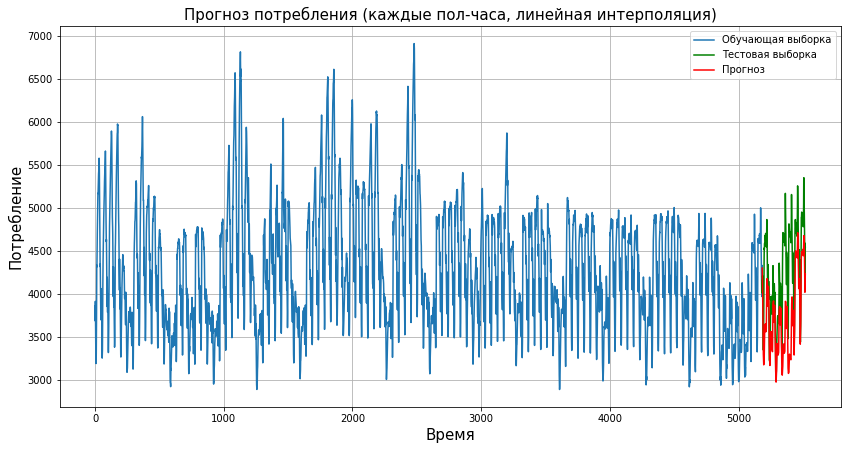

In [61]:
plt.figure(figsize=(14,7))
grid_train = np.arange(len(X_train_cons))
grid_test = np.arange(len(X_train_cons), len(X_train_cons) + len(X_test_cons))

p_meaned = []
for i in range(len(p)):  # "сезонное интегрирование"
    p_meaned.append(p[i] +
                    y_meaned_cons[len(y_meaned_cons) + i - week] 
                    if len(y_meaned_cons) + i - week < len(y_meaned_cons)
                    else p_meaned[i - week])
#p_meaned = np.exp(np.array(p_meaned))
predicted_cons = []

for i in range(len(grid_test)):
    if (i//meaner + 1 < len(grid_test)):
        avg = (p_meaned[i//meaner] * (meaner - i % meaner) + p_meaned[i//meaner + 1] * (i % meaner)) / meaner
        predicted_cons.append(avg)
    else:
        predicted_cons.append(p_meaned[i//meaner])
        
plt.plot(grid_train, X_train_cons, label="Обучающая выборка")
plt.plot(grid_test, X_test_cons, color="green", label="Тестовая выборка")
plt.plot(grid_test, predicted_cons, color="red", label="Прогноз")
plt.legend()
plotlabels("Время", "Потребление", "Прогноз потребления (каждые пол-часа, линейная интерполяция)")
plt.show()

Посмотрим, что там напредсказано. На графике выше как минимум предсказаны дневные циклы (минимумы-максимумы совпадают по времени, чего не было бы при кривом усреднении)

In [62]:
predicted_cons = np.array(predicted_cons)
X_test_cons = np.array(X_test_cons)
list(zip(predicted_cons, X_test_cons))[:5]

[(4298.4587625000177, 4154.9702006666703),
 (4218.1147019475466, 4008.6524800000002),
 (4137.7706413950746, 4210.4255119999998),
 (4057.4265808426026, 4120.6523066666714),
 (3977.0825202901315, 3882.2153026666711)]

In [65]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(predicted_cons, X_test_cons)
rmse = mse ** 0.5
print("MSE = %.2f, RMSE = %.2f" % (mse, rmse))

MSE = 455332.45, RMSE = 674.78


Выше приведён RMSE модели, он более интерпретируемый.

### Температура

In [66]:
end = len(X_train_temp) + len(X_test_temp)
pred = best_temp_model.get_prediction(start=len(y) - 1, end = end // meaner, dynamic=True)
pred_ci = pred.conf_int()
p = pred.predicted_mean

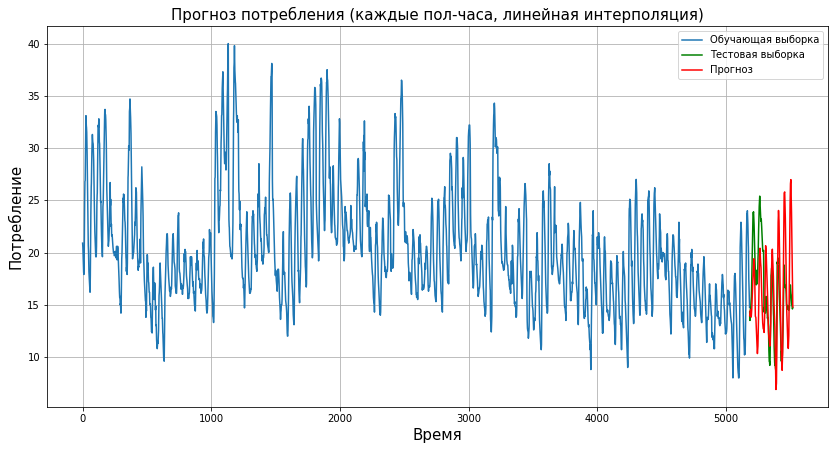

In [67]:
plt.figure(figsize=(14,7))
grid_train = np.arange(len(X_train_temp))
grid_test = np.arange(len(X_train_temp), len(X_train_temp) + len(X_test_temp))

p_meaned = []
for i in range(len(p)):
    p_meaned.append(p[i] +
                    y_meaned_temp[len(y_meaned_temp) + i - week] 
                    if len(y_meaned_temp) + i - week < len(y_meaned_temp)
                    else p_meaned[i - week])
#p_meaned = np.exp(np.array(p_meaned))
predicted_temp = []

for i in range(len(grid_test)):
    if (i//meaner + 1 < len(grid_test)):
        avg = (p_meaned[i//meaner] * (meaner - i % meaner) + p_meaned[i//meaner + 1] * (i % meaner)) / meaner
        predicted_temp.append(avg)
    else:
        predicted_temp.append(p_meaned[i//meaner])
        


plt.plot(grid_train, X_train_temp, label="Обучающая выборка")
plt.plot(grid_test, X_test_temp, color="green", label="Тестовая выборка")
plt.plot(grid_test, predicted_temp, color="red", label="Прогноз")
plt.legend()
plotlabels("Время", "Потребление", "Прогноз потребления (каждые пол-часа, линейная интерполяция)")
plt.show()

Прогноз и тестовая выборка:

In [68]:
predicted_temp = np.array(predicted_temp)
X_test_temp = np.array(X_test_temp)
list(zip(predicted_temp, X_test_temp))[:5]

[(13.947869669662033, 14.300000000000001),
 (14.079381371751644, 13.9),
 (14.210893073841255, 13.5),
 (14.342404775930866, 13.65),
 (14.473916478020477, 13.800000000000001)]

In [71]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(predicted_temp, X_test_temp)
rmse = mse ** 0.5
print("MSE = %.2f, RMSE = %.2f" % (mse, rmse))

MSE = 20.40, RMSE = 4.52


8.Добавьте в модель предсказания электричества экзогенные факторы:

(a) Дневную и месячную сезонность (очевидно, они известны заранее). Однако, в
том виде как они записаны в таблице применять не хорошо — может работать
плохо, поэтому стоит использовать гармоники Фурье — синусы с периодом, де-
лящим период сезонности. Их использование может позволить учесть сложные
сезонности.

(b) Значения температуры, используя на тестовом интервале времени истинные зна-
чения температуры (нечестный способ).

(c) Значения температуры, используя на тестовом интервале времени предсказания
значений температуры.

(d) Вместе (a) и (c).

(e) * Использование значений температуры по частям — для получения прогноза
y ̂︀ T +h|T строится своя модель по временному ряду y h , ..., y T с рядом экзогенного
фактора x 1 , ..., x T −h . Тогда для получения прогноза y ̂︀ T +h|T нужно знать значения
x T −h+1 , ..., x T , которые известны на момент построения модели.

(f) * Вместе (a) и (e).

9.Сравните все предсказания по метрике MSE.